In [37]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os

# 01_data_preparation.ipynb ile aynı BASE_DIR
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Sugarcane Disease"
SPLIT_DIR = os.path.join(BASE_DIR, "dataset_split")

train_dir = os.path.join(SPLIT_DIR, "train")
val_dir   = os.path.join(SPLIT_DIR, "val")
test_dir  = os.path.join(SPLIT_DIR, "test")

print("TRAIN:", train_dir)
print("VAL  :", val_dir)
print("TEST :", test_dir)

print("Train klasörü var mı?", os.path.exists(train_dir))
print("Val   klasörü var mı?", os.path.exists(val_dir))
print("Test  klasörü var mı?", os.path.exists(test_dir))


TRAIN: /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/train
VAL  : /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/val
TEST : /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/test
Train klasörü var mı? True
Val   klasörü var mı? True
Test  klasörü var mı? True


In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize


In [40]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıflar:", class_names)
print("Sınıf sayısı:", num_classes)


Found 1762 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 509 files belonging to 5 classes.
Sınıflar: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Sınıf sayısı: 5


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import numpy as np
import os

# 1. Sınıf Ağırlıklarını Hesapla (Dengesiz Veri Seti Çözümü)
# Eğitim setindeki etiketleri alıyoruz
train_labels = []
for images, labels in train_ds.unbatch():
    train_labels.append(np.argmax(labels.numpy()))

train_labels = np.array(train_labels)

# Sklearn ile ağırlıkları hesapla
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
# Keras'ın anlayacağı formata (Dictionary) çevir
class_weights_dict = dict(enumerate(class_weights))
print("Sınıf Ağırlıkları:", class_weights_dict)

# 2. Daha Agresif Veri Artırma
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

# 3. DenseNet121 Modeli (Doku Tanıma Uzmanı)
def build_densenet_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)

    # DenseNet121: Yaprak hastalıklarında genellikle en iyi sonucu verir
    base_model = DenseNet121(include_top=False, input_tensor=x, weights="imagenet")

    # İPUCU: DenseNet'in tüm katmanlarını hemen eğitime açıyoruz (Transfer Learning yerine Full Training)
    # Veri seti küçük olduğu için bu bazen daha iyi sonuç verir.
    base_model.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x) # Dropout yüksek tutuldu

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="DenseNet121_Final")

    # Learning Rate çok düşük başlatılır çünkü tüm katmanlar açık
    model.compile(
        optimizer=optimizers.Adamax(learning_rate=1e-4), # Adamax bazen Adam'dan daha stabildir
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_densenet_model(num_classes=5)

Sınıf Ağırlıkları: {0: np.float64(0.9654794520547946), 1: np.float64(1.0910216718266255), 2: np.float64(0.9734806629834254), 3: np.float64(0.9816155988857939), 4: np.float64(0.998300283286119)}


In [67]:
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [68]:
# 4. Callbacks
checkpoint = ModelCheckpoint("best_densenet_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# 5. EĞİTİM (Class Weights Eklenmiş Halde)
print("--- DenseNet121 ile Eğitim Başlıyor ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60, # Uzun eğitim
    class_weight=class_weights_dict, # KRİTİK NOKTA BURASI
    callbacks=[checkpoint, reduce_lr, early_stop],
    verbose=1
)

--- DenseNet121 ile Eğitim Başlıyor ---
Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.3892 - loss: 1.5696
Epoch 1: val_accuracy improved from -inf to 0.49600, saving model to best_densenet_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 856ms/step - accuracy: 0.3909 - loss: 1.5647 - val_accuracy: 0.4960 - val_loss: 1.2145 - learning_rate: 1.0000e-04
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6539 - loss: 0.8861
Epoch 2: val_accuracy improved from 0.49600 to 0.65200, saving model to best_densenet_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 680ms/step - accuracy: 0.6544 - loss: 0.8849 - val_accuracy: 0.6520 - val_loss: 0.9344 - learning_rate: 1.0000e-04
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.7480 - loss: 0.6744
Epoch 3: val_accuracy improved from 0.65200 to 0.76800, saving model to best_densenet_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 679ms/step - accuracy: 0.7482 - loss: 0.6738 - val_accuracy: 0.7680 - val_loss: 0.7142 

In [69]:
test_loss, test_acc = vgg16_model.evaluate(test_ds)
print(f"VGG16 Test Accuracy: {test_acc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8491 - loss: 0.4106
VGG16 Test Accuracy: 0.8173


In [70]:
# Model adını değiştirdik: vgg16_model -> model
test_loss, test_acc = model.evaluate(test_ds)
print(f"EfficientNet Test Accuracy: {test_acc:.4f}")

# Rapor kısmı için güncel kod:
import numpy as np
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    # BURADA DİKKAT: 'model' değişkenini kullanıyoruz
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.9628 - loss: 0.0982
EfficientNet Test Accuracy: 0.9489
              precision    recall  f1-score   support

     Healthy       0.89      0.99      0.94       105
      Mosaic       0.95      0.90      0.93        93
      RedRot       0.95      0.99      0.97       105
        Rust       0.98      0.97      0.98       104
      Yellow       0.98      0.88      0.93       102

    accuracy                           0.95       509
   macro avg       0.95      0.95      0.95       509
weighted avg       0.95      0.95      0.95       509



In [71]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    matthews_corrcoef, classification_report, confusion_matrix
)

acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print("=== VGG16 Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


=== VGG16 Test Metrics ===
Accuracy: 0.9489
Balanced Accuracy: 0.9475
Precision: 0.9510
Recall: 0.9489
F1-score: 0.9487
MCC: 0.9367

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.99      0.94       105
      Mosaic       0.95      0.90      0.93        93
      RedRot       0.95      0.99      0.97       105
        Rust       0.98      0.97      0.98       104
      Yellow       0.98      0.88      0.93       102

    accuracy                           0.95       509
   macro avg       0.95      0.95      0.95       509
weighted avg       0.95      0.95      0.95       509



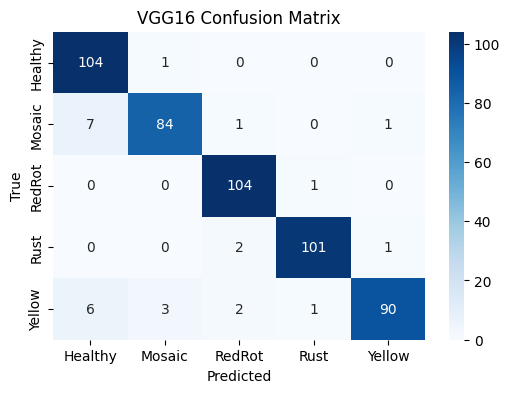

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


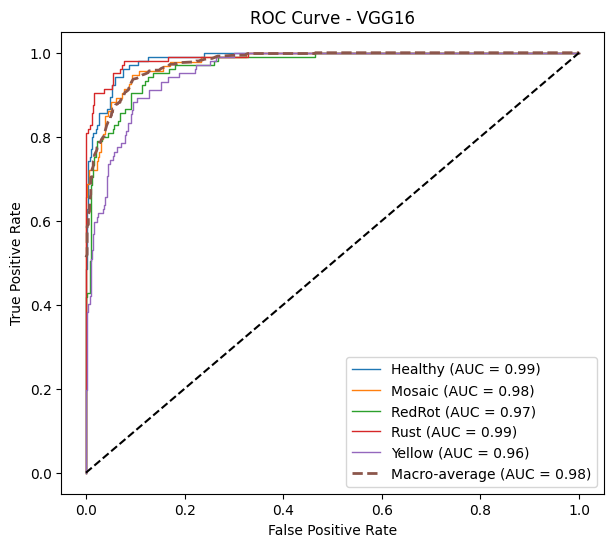

In [73]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=1,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(all_fpr, mean_tpr, linestyle='--', lw=2,
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - VGG16")
plt.legend()
plt.show()


In [74]:
vgg_save_path = os.path.join(BASE_DIR, "vgg16_best_model.h5")
vgg16_model.save(vgg_save_path)

print("VGG16 modeli kaydedildi:", vgg_save_path)


VGG16 modeli kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/vgg16_best_model.h5
